#   MASTER
## Welcome to mat2py tool. This applies SH to process GRACE SH coefficients into Terrestrial water storage changes
#### Kindly provide the paths to respective files and outputs
#### 1. Reading SH coeffs from NASA JPL and replacing degree 1,2,3 coeffs'

In [39]:
pwd

'/Users/vivek/Desktop/vivek_desktop/vivek_git/pyshbundle/pyshbundle'

In [40]:
path_sh = r"/Users/vivek/Desktop/vivek_desktop/vivek_git/pyshbundle/sample_input_data/JPL_input"                      # Path to JPL GRACE data
path_tn14 = r"/Users/vivek/Desktop/vivek_desktop/vivek_git/pyshbundle/pyshbundle/data/JPL_TN_files/TN-14_C30_C20_GSFC_SLR.txt"    # Path to TN14
path_tn13 = r"/Users/vivek/Desktop/vivek_desktop/vivek_git/pyshbundle/pyshbundle/data/JPL_TN_files/TN-13_GEOC_JPL_RL06.txt"       # Path to TN13
source='jpl'

In [46]:
import os
path_master = os.getcwd()                                            # current directory
# path_functions = os.path.join(path_master,"pyshbundle")        # directory of the sh bundle functions
path_functions = path_master;
path_output = os.path.join(os.path.dirname(path_master),"output")    # directory for output
os.chdir(path_functions)

In [47]:
ls 

GRACE_Data_Driven_Correction_Vishwakarma.py
GRACEconstants.py
GRACEpy.py
Phase_calc.py
__init__.py
__pycache__/
basin_avg.py
clm2cs.py
clm2sc.py
cs2sc.py
data/
eigengrav.py
gaussian.py
grule.py
gsha.py
gshs.py
iplm.py
ispec.py
klm2sc.py
load_longterm_mean.py
master.ipynb
naninterp.py
neumann.py
new_io.py
normalklm.py
plm.py
pyshbundle.py
read_GRACE_SH_paths.py
reader_replacer.py
reader_replacer_csr.py
reader_replacer_itsg.py
reader_replacer_jpl.py
sc2cs.py
tws_cal.py
validation_pyshbundle.ipynb
visualisation_utils.py


In [48]:
from reader_replacer_jpl import reader_replacer_jpl
from reader_replacer_csr import reader
from reader_replacer_itsg import reader
from klm2sc import klm2sc
from clm2sc import clm2sc
from tws_cal import tws_cal
# from basin_avg import basin_avg
import numpy as np
import pandas as pd
import xarray as xr
import warnings
warnings.filterwarnings('ignore')

In [49]:
%%time
if source == 'jpl':
    sh_clm, dates_start, dates_end, no_of_files = reader_replacer_jpl(path_sh, path_tn14, path_tn13)
elif source == 'csr':
    sh_clm, dates_start, dates_end, no_of_files = reader_replacer_csr(path_sh, path_tn14, path_tn13)
elif source=='itsg':
    sh_clm, dates_start, no_of_files = reader_replacer_itsg(path_sh, path_tn14, path_tn13)

JPL
Reading into clm format complete!
Number of files read: 201
Starting replacement
found: 37
2002-04-04 2002-04-04 0
2002-05-02 2002-05-02 1
2002-08-01 2002-08-01 2
2002-09-01 2002-09-01 3
2002-10-01 2002-10-01 4
2002-11-01 2002-11-01 5
2002-12-01 2002-12-01 6
2003-01-01 2003-01-01 7
2003-02-01 2003-02-01 8
2003-03-01 2003-03-01 9
2003-04-01 2003-04-01 10
2003-05-01 2003-05-01 11
2003-07-01 2003-07-01 12
2003-08-01 2003-08-01 13
2003-09-01 2003-09-01 14
2003-10-01 2003-10-01 15
2003-11-01 2003-11-01 16
2003-12-01 2003-12-01 17
2004-01-01 2004-01-01 18
2004-02-04 2004-02-04 19
2004-03-01 2004-03-01 20
2004-04-01 2004-04-01 21
2004-05-01 2004-05-01 22
2004-06-01 2004-06-01 23
2004-11-01 2004-11-01 28
2004-12-01 2004-12-01 29
2005-01-01 2005-01-01 30
2005-02-01 2005-02-01 31
2005-03-01 2005-03-01 32
2005-04-01 2005-04-01 33
2005-05-01 2005-05-01 34
2005-06-01 2005-06-01 35
2005-07-01 2005-07-01 36
2005-08-01 2005-08-01 37
2005-09-01 2005-09-01 38
2005-10-01 2005-10-01 39
2005-11-01 2005

* `sh_clm` is a ndarray containg lists of data: degree;  order; clm; slm; delta clm; delta slm; start data; end date*

#### 2. The following cells perform a bunch of operations


* Storing SH coeffs in clm format into SC format
* Calculation of delta clm & delta slm
* Application of Gaussian filter/filter of user choice
* Application of filter to delta clm, slm to get filtered SH coeffs
* Calling gshs() with filtered SH coeffs to obtain TWS fields
* Flipping the TWS fields to get 0 degree longitude in the middle
* Saving data in netCDF4 format and writing to disk

In [51]:
if source == 'jpl':
    raw_sc = clm2sc(sh_clm)[0];
elif source == 'csr':
    raw_sc = klm2sc(sh_clm);
elif source== 'itsg':
    raw_sc = clm2sc(sh_clm);

Conversion into clm format complete


In [9]:
lmax = 96
gs = 1
half_rad_gf = 500

In [10]:
lon = np.arange(-180,180,gs)
lat = np.arange(89,-91,-gs)
# dates = pd.to_datetime(pd.Series(dates_start), format='%Y-%m-%d').dt.strftime('%d-%m-%Y') \
#         + "    " \
#         +pd.to_datetime(pd.Series(dates_end), format='%Y-%m-%d').dt.strftime('%d-%m-%Y')
dates = pd.to_datetime(pd.Series(dates_start), format='%Y-%m-%d')#.dt.strftime('%d-%m-%Y')
print('dates read! \n')

dates read! 



##### Remove long term mean to get anomalies
* Long term mean is calculated from NASA JPL SH coeffs in the period 01-01-2005 & 31-12-2010 (6 years continuous)

In [11]:
len(raw_sc)

201

In [12]:
SH_long_mean_jpl = np.load(path_master+'/pyshbundle/data/long_mean/SH_long_mean_jpl.npy')    # load the long term mean SH coeffs---> JPL 
# SH_long_mean_csr = np.load(path_master+'/long_mean/SH_long_mean_csr.npy')    # load the long term mean SH coeffs---> CSR
# SH_long_mean_itsg = np.load(path_master+'/long_mean/SH_long_mean_itsg.npy')    # load the long term mean SH coeffs---> ITSG
if source== 'jpl':
    delta_sc = raw_sc - SH_long_mean_jpl
elif source== 'csr':
    delta_sc = raw_sc - SH_long_mean_csr
elif source== 'itsg':
    delta_sc = raw_sc - SH_long_mean_itsg

In [13]:
import calendar

In [14]:
new_data = {}

# Create years from 2002 to 2023
new_data['years'] = {}
for year in range(2002, 2023):
    new_data['years'][year] = {}

    # Create months within each year
    new_data['years'][year]['months'] = {}
    for month in range(1, 13):
        month_name = calendar.month_abbr[month]
        new_data['years'][year]['months'][month_name] = np.zeros_like(delta_sc[0]) * np.nan; 

# Accessing an element from the renamed structure
# year = 2021
# month_name = 'Apr'  # April's key after renaming
# row = 2
# col = 5

# specific_element = new_data['years'][year]['months'][month_name] [row][col]
# print("Specific element:", specific_element)
# print(new_data)

#### 
* This structure will store all the SH coeffs from GRACE/GRACE-FO without gaps, \
corresponding to each key-value (year-month) pair. 

In [15]:
date_series = pd.to_datetime(dates)
date_series = pd.DatetimeIndex(date_series)

# Create a structure to store years and months
dates_structure = {}
dates_structure['years'] = {}

# Extract unique years from the DatetimeIndex
unique_years = date_series.year.unique()

index=0;
# For each year, extract unique months and store in the structure
for year in unique_years:
    year_months = date_series[date_series.year == year].month.unique()
    # print(year_months)
    ''' neater way to do this but couldn't implement '''
    # year_month_names = [{calendar.month_abbr[month]: delta_sc[index]} for month, index in enumerate (year_months, index)] 
    # dates_structure['years'][year] = {'months': year_month_names[0]}
    year_month_names = [];
    for month in year_months:
        month_name = calendar.month_abbr[month]
        year_month_names.append({month_name: delta_sc[index]})
        # print(year_months)
        # print(month_name)
        index += 1
    dates_structure['years'][year] = {'months': year_month_names}

# Print the created structure
# import pprint
# pprint.pprint(dates_structure)

In [16]:
dates_structure['years'][2022]

{'months': [{'Jan': array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          ...,
          [ 0.00000000e+00,  0.00000000e+00, -9.44186717e-11, ...,
           -4.61038776e-11,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  1.76459418e-11, -4.94320914e-11, ...,
            1.29085522e-10, -4.25474555e-11,  0.00000000e+00],
          [-4.85702348e-11,  1.72062141e-10,  2.75331440e-10, ...,
            1.22027639e-10, -4.29833385e-11, -4.52972386e-11]])},
  {'Feb': array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.

In [17]:
for key in dates_structure['years'].keys():
    # print(key)    
    for list_index, key2 in enumerate(dates_structure['years'][key]['months']):
        # print(key2.keys(), list_index)
        for key3 in key2.keys():
            # print(key3)
            new_data['years'][key]['months'][key3] = dates_structure['years'][key]['months'][list_index][key3];

In [19]:
stripped_new_data = np.zeros([252,97,193])*np.nan;
index2=0;
for key in new_data['years'].keys():
    # print(key)    
    for list_index, key2 in enumerate(new_data['years'][key]['months']):
        # print(key2, list_index) 
        stripped_new_data[index2] = new_data['years'][key]['months'][key2]
        index2 = index2 +1;
        # for key3 in key2.keys():
        #     # print(key3)
        #     stripped_new_data[index2] = new_data['years'][key]['months'][key3]
        #     index2 = index2 +1;

In [20]:
# size check
stripped_new_data.shape, index2, (2022-2002+1)*12

((252, 97, 193), 252, 252)

In [53]:
import scipy.io

In [54]:
# Save the NumPy matrix to a .mat file
scipy.io.savemat(os.path.join(path_master,'delta_sc.mat'), {'delta_sc': stripped_new_data})

  0%|          | 0/252 [00:00<?, ?it/s]

100%|██████████| 252/252 [00:13<00:00, 18.92it/s]


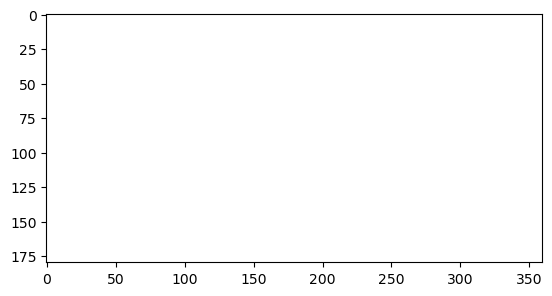

In [21]:
# %%time
tws_fields = tws_cal(stripped_new_data,lmax,gs,half_rad_gf,int(stripped_new_data.shape[0]))
tws_fields = np.float32(tws_fields)

In [22]:
dates_for_stripped = pd.date_range(start ='2002-01-01', periods=stripped_new_data.shape[0], freq ='M')
dates_for_stripped

DatetimeIndex(['2002-01-31', '2002-02-28', '2002-03-31', '2002-04-30',
               '2002-05-31', '2002-06-30', '2002-07-31', '2002-08-31',
               '2002-09-30', '2002-10-31',
               ...
               '2022-03-31', '2022-04-30', '2022-05-31', '2022-06-30',
               '2022-07-31', '2022-08-31', '2022-09-30', '2022-10-31',
               '2022-11-30', '2022-12-31'],
              dtype='datetime64[ns]', length=252, freq='M')

In [23]:
dates_for_stripped = pd.date_range(start ='2002-01-01', periods=stripped_new_data.shape[0], freq ='M')
ds = xr.Dataset(
    data_vars=dict(
        tws=(["time","lat", "lon"], tws_fields)
    ),
    coords = {
        "time":(('time'),dates_for_stripped),
        "lat":lat,
        "lon":lon },
    attrs=dict(description="TWS Anomaly corresponding to long term (2004-2010) mean \n lmax=96 and half radius of Gaussian filter = 500Km"),
)
ds

<xarray.Dataset>
Dimensions:  (time: 252, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 2002-01-31 2002-02-28 ... 2022-12-31
  * lat      (lat) int64 89 88 87 86 85 84 83 82 ... -84 -85 -86 -87 -88 -89 -90
  * lon      (lon) int64 -180 -179 -178 -177 -176 -175 ... 175 176 177 178 179
Data variables:
    tws      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    description:  TWS Anomaly corresponding to long term (2004-2010) mean \n ...

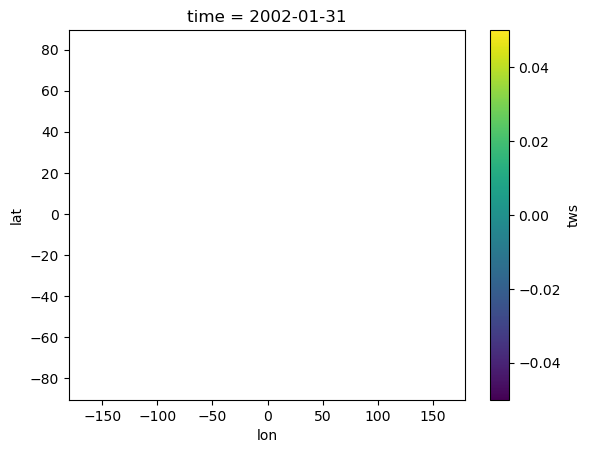

In [24]:
ds.tws.isel(time=0).plot()

In [25]:
ds.time.isel(time=-1)

<xarray.DataArray 'time' ()>
array('2022-12-31T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2022-12-31

In [55]:
ds.to_netcdf(os.path.join(path_master,'tws_py.nc'), engine="netcdf4")

## Basin average

In [26]:
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping
import matplotlib.pyplot as plt

<Axes: >

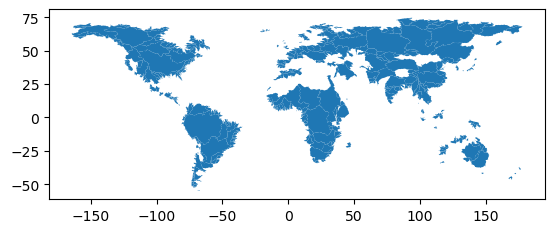

In [27]:
# import shapefile
# using HydroBasins shapefile 
path = '/Users/vivek/Desktop/vivek_downloads/mrb_shp_zip/mrb_basins.shp'
shp = gpd.read_file(path)
shp.plot()  

In [28]:
shp.head()

,MRBID,RIVER_BASI,CONTINENT,SEA,OCEAN,SUM_SUB_AR,Shape_Leng,Shape_Area,geometry
0,1201,ATOUI,Africa,North Atlantic,Atlantic Ocean,27695.4,11.874010,2.409224,"POLYGON ((-13.71723 22.88554, -13.71667 22.879..."
1,1202,BANDAMA,Africa,Gulf of Guinea,Atlantic Ocean,99254.1,18.506812,8.107313,"POLYGON ((-5.37917 6.21250, -5.38034 6.21708, ..."
2,1203,BIA,Africa,Gulf of Guinea,Atlantic Ocean,10957.1,7.141522,0.891547,"POLYGON ((-2.69497 7.34616, -2.68797 7.34105, ..."
3,1204,CAVALLY,Africa,Gulf of Guinea,Atlantic Ocean,29622.9,13.092576,2.408952,"POLYGON ((-8.26748 7.93681, -8.26605 7.92701, ..."
4,1205,CESTOS (also NUON),Africa,North Atlantic,Atlantic Ocean,12785.0,8.018670,1.040702,"POLYGON ((-8.38159 7.58785, -8.36667 7.58750, ..."


In [29]:
temp=shp['RIVER_BASI']   # find your basin name from this variables
basin_name='GANGES'

Basin area is : 90946879544400.0 m²


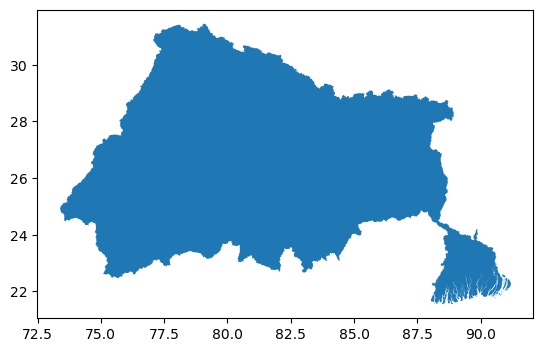

In [30]:
shp_hel=shp[shp['RIVER_BASI']==basin_name]
# print(shp_hel.head())
shp_hel.plot()
basin_area=np.float64(shp_hel['Shape_Area'])*1e12 # basin area already in m^2
print('Basin area is :', basin_area, 'm\u00b2');

In [31]:
''' Area weighting '''
# Calculation of area of each corresponding to  the latitudes and longitudes
deg = 1;
x = np.linspace(0, 359+(1-deg), int(360/deg), dtype='double');
y = np.linspace(0, 179+(1-deg), int(180/deg), dtype='double');
x1 = np.linspace(1*deg, 360, int(360/deg), dtype='double');
y1 = np.linspace(1*deg, 180, int(180/deg), dtype='double');
lambd,theta = np.meshgrid(x,y)  
lambd1,theta1 = np.meshgrid(x1,y1)  
a = np.sin(np.deg2rad(90-theta))-np.sin(np.deg2rad(90-theta1))
b = (lambd1 - lambd)*np.pi/180


# Area of each grid (360*720)
area = (6378.137**2)*pow(10,6)*(np.multiply(a,b))        # units m^2

In [32]:
temp_csr = ds*area
temp_csr

<xarray.Dataset>
Dimensions:  (time: 252, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 2002-01-31 2002-02-28 ... 2022-12-31
  * lat      (lat) int64 89 88 87 86 85 84 83 82 ... -84 -85 -86 -87 -88 -89 -90
  * lon      (lon) int64 -180 -179 -178 -177 -176 -175 ... 175 176 177 178 179
Data variables:
    tws      (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    description:  TWS Anomaly corresponding to long term (2004-2010) mean \n ...

In [69]:
# clip data using shapefile
''' add projection system to nc '''
basin_tws = temp_csr.rio.write_crs("EPSG:4326", inplace=True)
basin_tws = basin_tws.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
        
# mask data with shapefile
basin_tws = basin_tws.rio.clip(shp.geometry.apply(mapping), shp.crs,drop=False)
basin_avg_tws=basin_tws.sum(dim=('lon','lat'), skipna=True)/basin_area  #basin average tws


# this to remove the WGS84 grid mapping so I can save the file, don't do this for basin scale avg time series
# basin_tws2 = basin_tws.reset_coords(names='WGS84', drop=True)
# del basin_tws2.attrs['grid_mapping']
# basin_tws2

In [70]:
basin_tws

<xarray.Dataset>
Dimensions:      (time: 252, lat: 180, lon: 360)
Coordinates:
  * time         (time) datetime64[ns] 2002-01-31 2002-02-28 ... 2022-12-31
  * lat          (lat) int64 89 88 87 86 85 84 83 ... -85 -86 -87 -88 -89 -90
  * lon          (lon) int64 -180 -179 -178 -177 -176 ... 175 176 177 178 179
    spatial_ref  int64 0
Data variables:
    tws          (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    description:  TWS Anomaly corresponding to long term (2004-2010) mean \n ...

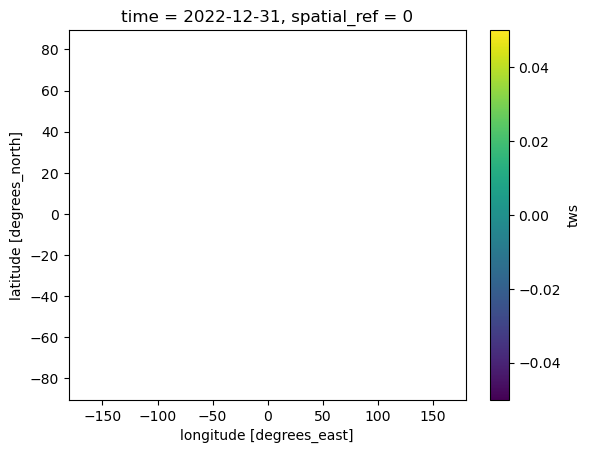

In [78]:
basin_tws.tws.isel(time=-1,).plot()

In [72]:
basin_avg_tws

<xarray.Dataset>
Dimensions:      (time: 252)
Coordinates:
  * time         (time) datetime64[ns] 2002-01-31 2002-02-28 ... 2022-12-31
    spatial_ref  int64 0
Data variables:
    tws          (time) float64 0.0 0.0 0.0 29.83 29.06 ... 0.0 0.0 0.0 0.0 0.0

In [73]:
nan_mask = np.all(np.isnan(basin_tws.tws.values), axis=(1, 2))

In [74]:
nan_mask

array([ True,  True,  True, False, False,  True,  True, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False,  True, False, False, False,
       False,  True, False, False, False, False,  True,  True,  True,
        True, False,

In [75]:
basin_avg_tws = basin_avg_tws.where(~nan_mask, np.nan)

In [76]:
basin_avg_tws.tws

<xarray.DataArray 'tws' (time: 252)>
array([         nan,          nan,          nan,  29.82637732,
        29.06033961,          nan,          nan, -16.94457524,
       -33.40073342, -35.2944153 , -27.28824642, -24.90011199,
        -8.00622785,  -1.29972256,   9.98150968,  13.85523093,
        11.9311066 ,          nan,  -8.86863636, -20.86670307,
       -25.03921337, -34.459384  , -27.82564156, -15.99001743,
        -4.69467843,  11.34605978,  15.46880426,  26.51688469,
        19.72142446,  10.71304639,          nan,          nan,
                nan,          nan, -17.23781782,  -7.19096417,
         0.95305119,  15.98813934,  24.33666747,  21.42955325,
        24.57971777,   2.17542771, -13.86515511, -24.19558406,
       -30.30534236, -31.19648071, -31.58727521, -18.27905298,
        -3.99174471,   7.19484866,  21.86451945,  29.86318829,
        19.2135665 ,   7.56390211, -14.11543849, -24.95708084,
       -34.47777111, -35.91345391, -20.20322857,  -6.02469976,
        10.65038028,  19.36985429,  25.74898164,  27.83580262,
        24.18106499,  10.86347347,  -4.20322032, -13.6562895 ,
       -25.08307239, -30.55479084, -25.89974438, -11.6329585 ,
         0.81337964,  19.87563164,  34.63701538,  37.85987254,
        28.98441261,  12.01736704,  -1.19257333,  -8.84811416,
...
        -6.67558782,   3.84973687,  13.67673277,  17.71870294,
                nan,          nan,   6.22868805,  -7.86885708,
       -22.82599547,          nan, -20.81344542,  -9.11799934,
        14.19165429,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,  33.60352919,  29.55074068,          nan,
                nan,  30.49694802,  22.85301435,  21.64901697,
         6.94349539,          nan, -17.41145536, -11.50041853,
         2.72002317,  10.37050699,  20.97266462,  26.40503241,
        30.53964874,  30.61344656,  12.04627056,  -6.83927483,
       -12.63789943, -19.3550449 , -18.95722146, -12.36318085,
         4.1639635 ,  18.99110627,  35.61175408,  39.30434992,
        46.26764267,  40.30237832,  18.03499776,   6.81588789,
        -2.14916604,  -4.18905909, -11.85696741,  -9.91778273,
        -1.61354213,  18.44179367,  29.15075678,  42.2171918 ,
        44.76055559,  39.70435359,  21.47262369,   8.0400732 ,
        -7.72323652, -10.34526575, -21.30008556,  -7.66033184,
         1.85413543,  20.23261526,          nan,          nan,
                nan,          nan,          nan,          nan])
Coordinates:
  * time         (time) datetime64[ns] 2002-01-31 2002-02-28 ... 2022-12-31
    spatial_ref  int64 0

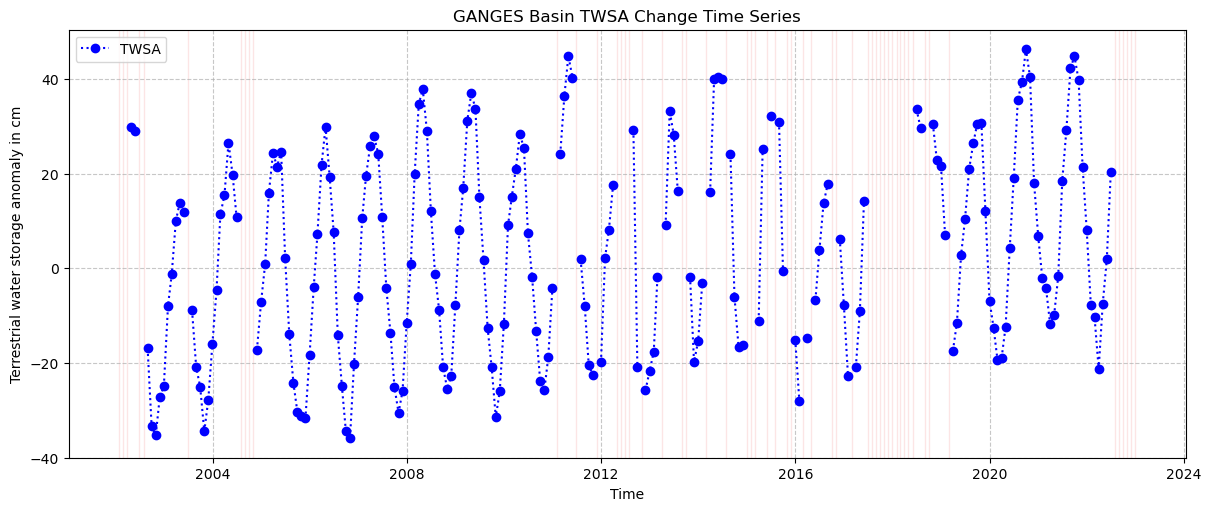

In [77]:
# Create the basin avg time-series plot
plt.figure(figsize=(12, 5), constrained_layout=True)

# Plot with a dotted line and markers
plt.plot(basin_avg_tws.time, basin_avg_tws.tws.values, label='TWSA', linestyle='dotted', marker='o', color='b')

# Create vertical shaded regions for missing values
nan_variables = basin_avg_tws.time.values[nan_mask]
for xc in nan_variables:
    plt.axvspan(xc, xc, color='lightcoral', alpha=0.2)


# Add labels and title
plt.xlabel('Time')
plt.ylabel('Terrestrial water storage anomaly in cm')
plt.title(f'{basin_name} Basin TWSA Change Time Series')

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Add a legend
plt.legend()

# Show the plot
plt.show()
